# Data Exploration

## Setup

In [1]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.neighbors
import sklearn.ensemble
import sklearn.cluster
import sklearn.feature_selection
import matplotlib.pyplot as plt
import ast
import gensim, logging
import xgboost
import lightgbm
import datetime
import seaborn as sbn
import torch

C:\Users\caioj\Anaconda3\envs\forest-env\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
read_train_df = pd.read_csv('data/train.csv')
read_test_df = pd.read_csv('data/evaluation.csv')
read_train_df.describe()

,retweets_count,favorites_count,followers_count,statuses_count,friends_count,verified,timestamp,TweetID
count,353969.000000,353969.000000,3.539690e+05,3.539690e+05,353969.000000,353969.000000,3.539690e+05,3.539690e+05
mean,15.831810,46.655442,2.021548e+04,4.808507e+04,1459.289003,0.030005,1.647004e+12,6.872503e+05
std,241.986723,852.044385,2.598715e+05,1.133854e+05,2502.933271,0.170602,4.846468e+09,4.175793e+05
min,0.000000,0.000000,0.000000e+00,1.000000e+00,0.000000,0.000000,1.301178e+12,3.000000e+00
25%,0.000000,0.000000,1.600000e+02,2.972000e+03,214.000000,0.000000,1.647068e+12,3.194490e+05
50%,1.000000,0.000000,7.260000e+02,1.250100e+04,693.000000,0.000000,1.647292e+12,6.719730e+05
75%,3.000000,1.000000,2.283000e+03,4.352200e+04,1804.000000,0.000000,1.647532e+12,1.049644e+06
max,63674.000000,122591.000000,1.441710e+07,8.183508e+06,237269.000000,1.000000,1.647727e+12,1.434456e+06


In [3]:
read_train_df

,text,retweets_count,favorites_count,followers_count,statuses_count,friends_count,mentions,urls,verified,hashtags,timestamp,TweetID
0,rt refarcir macron ans nom prépare,3,0,3682,453535,3628,[],[],0,[],1646978048000,832509
1,populaire,0,0,86,1016,284,[],[],0,[],1647694288000,1388011
2,faut dégager cinglé,3,1,1944,28234,1995,[],[],0,[],1647370048000,63896
3,enseignants mettre prescriptions président rép...,0,0,1,1072,0,[],['https://t.co/rytlted08g'],0,[],1647256282000,979251
4,mafieuse oppressive macron,0,0,13957,25311,10841,[],[],0,[],1647258374000,1040049
...,...,...,...,...,...,...,...,...,...,...,...,...
353964,gonflette tour raciste frustré,0,0,34,1509,55,[],['https://t.co/pma33zhslx'],0,[],1647438153000,142573
353965,france caste crapuleuse encadrée gangsters irr...,0,0,89,11166,127,[],[],0,[],1647072106000,240866
353966,eric zemmour français berbère,3,0,1888,712,3086,[],[],0,[],1647607230000,1173763
353967,gauchistes dépression pq,0,0,139,486,320,[],[],0,[],1646987195000,929182


In [4]:
read_train_df['mentions'].apply(ast.literal_eval).apply(len).describe()

count    353969.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: mentions, dtype: float64

In [5]:
read_train_df.urls = read_train_df.urls.apply(ast.literal_eval)
read_train_df.hashtags = read_train_df.hashtags.apply(ast.literal_eval)

read_test_df.urls = read_test_df.urls.apply(ast.literal_eval)
read_test_df.hashtags = read_test_df.hashtags.apply(ast.literal_eval)

In [6]:
def format_df(df: pd.DataFrame,
                  type: str = 'train',
                  keep_time: bool = False):
    final_df = df.drop(['TweetID', 'mentions', 'timestamp'], axis=1)

    final_df['url_count'] = final_df.urls.apply(len)
    final_df['hashtag_count'] = final_df.hashtags.apply(len)

    if keep_time:
        timestamps = df.timestamp // 1000
        timestamps = timestamps.apply(datetime.datetime.fromtimestamp).apply(datetime.datetime.timetuple)

        time_df = pd.DataFrame(timestamps.tolist(), index=df.index,
                               columns=['tm_year', 'tm_mon', 'tm_mday', 'tm_hour', 'tm_min', 'tm_sec', 'tm_wday',
                                        'tm_yday', 'tm_isdst'])

        final_df = pd.concat([final_df, time_df], axis=1)

    return final_df

In [7]:
train_df = format_df(read_train_df, keep_time=True)
test_df = format_df(read_test_df, keep_time=True)

In [8]:
train_df

,text,retweets_count,favorites_count,followers_count,statuses_count,friends_count,urls,verified,hashtags,url_count,hashtag_count,tm_year,tm_mon,tm_mday,tm_hour,tm_min,tm_sec,tm_wday,tm_yday,tm_isdst
0,rt refarcir macron ans nom prépare,3,0,3682,453535,3628,[],0,[],0,0,2022,3,11,6,54,8,4,70,-1
1,populaire,0,0,86,1016,284,[],0,[],0,0,2022,3,19,13,51,28,5,78,-1
2,faut dégager cinglé,3,1,1944,28234,1995,[],0,[],0,0,2022,3,15,19,47,28,1,74,-1
3,enseignants mettre prescriptions président rép...,0,0,1,1072,0,[https://t.co/rytlted08g],0,[],1,0,2022,3,14,12,11,22,0,73,-1
4,mafieuse oppressive macron,0,0,13957,25311,10841,[],0,[],0,0,2022,3,14,12,46,14,0,73,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353964,gonflette tour raciste frustré,0,0,34,1509,55,[https://t.co/pma33zhslx],0,[],1,0,2022,3,16,14,42,33,2,75,-1
353965,france caste crapuleuse encadrée gangsters irr...,0,0,89,11166,127,[],0,[],0,0,2022,3,12,9,1,46,5,71,-1
353966,eric zemmour français berbère,3,0,1888,712,3086,[],0,[],0,0,2022,3,18,13,40,30,4,77,-1
353967,gauchistes dépression pq,0,0,139,486,320,[],0,[],0,0,2022,3,11,9,26,35,4,70,-1


In [9]:
train_df_input = train_df.drop(['retweets_count', 'text', 'urls', 'hashtags'], axis=1)
train_df_input

,favorites_count,followers_count,statuses_count,friends_count,verified,url_count,hashtag_count,tm_year,tm_mon,tm_mday,tm_hour,tm_min,tm_sec,tm_wday,tm_yday,tm_isdst
0,0,3682,453535,3628,0,0,0,2022,3,11,6,54,8,4,70,-1
1,0,86,1016,284,0,0,0,2022,3,19,13,51,28,5,78,-1
2,1,1944,28234,1995,0,0,0,2022,3,15,19,47,28,1,74,-1
3,0,1,1072,0,0,1,0,2022,3,14,12,11,22,0,73,-1
4,0,13957,25311,10841,0,0,0,2022,3,14,12,46,14,0,73,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353964,0,34,1509,55,0,1,0,2022,3,16,14,42,33,2,75,-1
353965,0,89,11166,127,0,0,0,2022,3,12,9,1,46,5,71,-1
353966,0,1888,712,3086,0,0,0,2022,3,18,13,40,30,4,77,-1
353967,0,139,486,320,0,0,0,2022,3,11,9,26,35,4,70,-1


In [10]:
def score_dataset(X, y, model=xgboost.XGBRegressor()):
    score = sklearn.model_selection.cross_val_score(
        model, X, y, cv=5, scoring='neg_mean_absolute_error'
    )
    score = - score.mean()
    return score

In [11]:
baseline_score = score_dataset(train_df_input.values, train_df['retweets_count'].values)
print(f'Baseline score: {baseline_score:.5f} MAE')

Baseline score: 6.68995 MAE


## Data Visualization, Feature Engineering

In [12]:
discrete_features = train_df_input.columns == 'verified'

mi_scores = sklearn.feature_selection.mutual_info_regression(train_df_input, train_df['retweets_count'], discrete_features=discrete_features)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=train_df_input.columns)
mi_scores = mi_scores.sort_values(ascending=False)

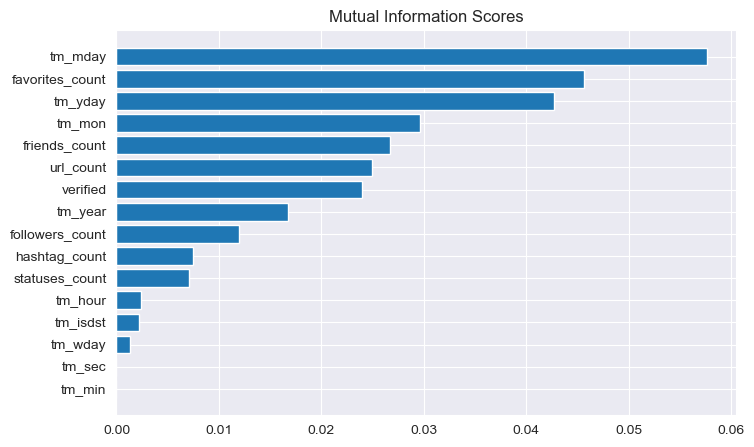

In [13]:
plt.figure(dpi=100, figsize=(8, 5))
mi_scores = mi_scores.sort_values(ascending=True)
width = np.arange(len(mi_scores))
ticks = list(mi_scores.index)
plt.barh(width, mi_scores)
plt.yticks(width, ticks)
plt.title("Mutual Information Scores")
plt.show()

In [14]:
new_train_df = train_df_input.drop(['tm_sec', 'tm_isdst'], axis=1)

In [15]:
baseline_score = score_dataset(new_train_df.values, train_df['retweets_count'].values)
print(f'Baseline score: {baseline_score:.5f} MAE')

Baseline score: 6.67358 MAE


C:\Users\caioj\Anaconda3\envs\forest-env\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\caioj\Anaconda3\envs\forest-env\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\caioj\Anaconda3\envs\forest-env\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


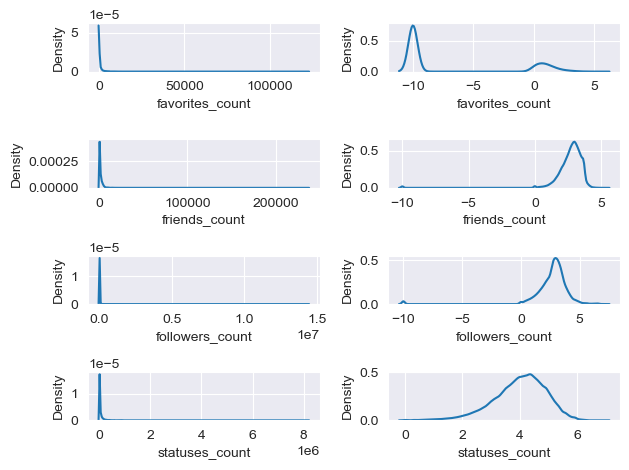

In [16]:
fig, ax = plt.subplots(4, 2)

sbn.kdeplot(ax=ax[0, 0], data=train_df.favorites_count)
sbn.kdeplot(ax=ax[0, 1], data=np.log10(train_df.favorites_count).replace([-np.inf], -10))
sbn.kdeplot(ax=ax[1, 0], data=train_df.friends_count)
sbn.kdeplot(ax=ax[1, 1], data=np.log10(train_df.friends_count).replace([-np.inf], -10))
sbn.kdeplot(ax=ax[2, 0], data=train_df.followers_count)
sbn.kdeplot(ax=ax[2, 1], data=np.log10(train_df.followers_count).replace([-np.inf], -10))
sbn.kdeplot(ax=ax[3, 0], data=train_df.statuses_count)
sbn.kdeplot(ax=ax[3, 1], data=np.log10(train_df.statuses_count).replace([-np.inf], -10))

fig.tight_layout()
plt.show()

In [17]:
new_train_df.favorites_count = np.log10(train_df_input.favorites_count).replace([-np.inf], -10)
new_train_df.friends_count = np.log10(train_df_input.friends_count).replace([-np.inf], -10)
new_train_df.followers_count = np.log10(train_df_input.followers_count).replace([-np.inf], -10)
new_train_df.statuses_count = np.log10(train_df_input.statuses_count).replace([-np.inf], -10)

C:\Users\caioj\Anaconda3\envs\forest-env\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [18]:
new_train_df

,favorites_count,followers_count,statuses_count,friends_count,verified,url_count,hashtag_count,tm_year,tm_mon,tm_mday,tm_hour,tm_min,tm_wday,tm_yday
0,-10.0,3.566084,5.656611,3.559667,0,0,0,2022,3,11,6,54,4,70
1,-10.0,1.934498,3.006894,2.453318,0,0,0,2022,3,19,13,51,5,78
2,0.0,3.288696,4.450772,3.299943,0,0,0,2022,3,15,19,47,1,74
3,-10.0,0.000000,3.030195,-10.000000,0,1,0,2022,3,14,12,11,0,73
4,-10.0,4.144792,4.403309,4.035069,0,0,0,2022,3,14,12,46,0,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353964,-10.0,1.531479,3.178689,1.740363,0,1,0,2022,3,16,14,42,2,75
353965,-10.0,1.949390,4.047898,2.103804,0,0,0,2022,3,12,9,1,5,71
353966,-10.0,3.276002,2.852480,3.489396,0,0,0,2022,3,18,13,40,4,77
353967,-10.0,2.143015,2.686636,2.505150,0,0,0,2022,3,11,9,26,4,70


In [19]:
baseline_score = score_dataset(new_train_df.values, train_df['retweets_count'].values)
print(f'Baseline score: {baseline_score:.5f} MAE')

Baseline score: 6.66898 MAE


In [20]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(new_train_df)

kmeans = sklearn.cluster.KMeans(n_clusters=9, random_state=0).fit(scaler.transform(new_train_df))

In [21]:
for i in range(kmeans.n_clusters):
    mean_rtwts = train_df[kmeans.labels_ == i]['retweets_count'].mean()
    print(f'Cluster {i} mean retweets: {mean_rtwts}')

Cluster 0 mean retweets: 8.248203788373612
Cluster 1 mean retweets: 0.7647979477041117
Cluster 2 mean retweets: 36.58391840486099
Cluster 3 mean retweets: 522.6975476839237
Cluster 4 mean retweets: 0.33579763716750016
Cluster 5 mean retweets: 12.027035119989733
Cluster 6 mean retweets: 132.6100561906607
Cluster 7 mean retweets: 0.7779877353108956
Cluster 8 mean retweets: 487.0807875084861


In [22]:
new_train_df['cluster'] = kmeans.labels_
new_train_df['cluster'] = new_train_df['cluster'].astype('category')

In [23]:
baseline_score = score_dataset(new_train_df.values, train_df['retweets_count'].values)
print(f'Baseline score: {baseline_score:.5f} MAE')

KeyboardInterrupt: 

In [ ]:
hashtags_temp = train_df.explode('hashtags')[['hashtags', 'retweets_count']].groupby('hashtags').mean()
hashtags_temp

In [ ]:
retweet_hash_avg = hashtags_temp.to_dict()['retweets_count']
retweet_hash_avg

In [ ]:
def get_list_avg(list_obj):
    sum = 0
    for hash in list_obj:
        sum += retweet_hash_avg[hash] if hash in retweet_hash_avg else -1.0
    return sum / len(list_obj) if list_obj else -1.0

new_train_df['retweet_hash_avg'] = train_df['hashtags'].apply(get_list_avg)

In [ ]:
baseline_score = score_dataset(new_train_df.values, train_df['retweets_count'].values)
print(f'Baseline score: {baseline_score:.5f} MAE')

In [ ]:
test_hashs = test_df.explode('hashtags')['hashtags'].unique()[1:]
sum = 0
for i in range(len(test_hashs)):
    if test_hashs[i] in retweet_hash_avg:
        sum += 1
print(sum, len(test_hashs))

In [25]:
def feature_engineering(df: pd.DataFrame, type: str = 'train'):
    final_df = df.drop(['text', 'urls', 'hashtags', 'tm_sec', 'tm_isdst'], axis=1)
    if type == 'train':
        final_df = final_df.drop('retweets_count', axis=1)

    # final_df.favorites_count = np.log10(final_df.favorites_count).replace([-np.inf], -10)
    # final_df.friends_count = np.log10(final_df.friends_count).replace([-np.inf], -10)
    # final_df.followers_count = np.log10(final_df.followers_count).replace([-np.inf], -10)
    # final_df.statuses_count = np.log10(final_df.statuses_count).replace([-np.inf], -10)
    #
    # scaler = sklearn.preprocessing.StandardScaler()
    # scaler.fit(final_df)
    #
    # kmeans = sklearn.cluster.KMeans(n_clusters=9, random_state=0).fit(scaler.transform(final_df))
    # final_df['cluster'] = kmeans.labels_
    #
    # final_df['retweet_hash_avg'] = df['hashtags'].apply(get_list_avg)

    return final_df

In [26]:
train_X = feature_engineering(train_df)
train_y = train_df['retweets_count']
test_X = feature_engineering(test_df, type='test')

In [27]:
train_X.columns

Index(['favorites_count', 'followers_count', 'statuses_count', 'friends_count',
       'verified', 'url_count', 'hashtag_count', 'tm_year', 'tm_mon',
       'tm_mday', 'tm_hour', 'tm_min', 'tm_wday', 'tm_yday'],
      dtype='object')

# NLP

In [ ]:
nlp_model = gensim.models.Word2Vec.load('models/word2vec.model')

train_tweets = read_train_df['text'].apply(str.split).to_list()
train_dictionary = gensim.corpora.Dictionary(train_tweets)
train_corpus = [train_dictionary.doc2bow(tweet) for tweet in train_tweets]

tfidf = gensim.models.TfidfModel(train_corpus)

In [ ]:
text = read_train_df['text']

text_embed = np.zeros((len(text), nlp_model.vector_size))

for i in range(len(text)):
    encoded_words = [word for word in text.iloc[i].split(' ') if word in nlp_model.wv and
                     word in train_dictionary.token2id]
    if encoded_words:
        keys = [train_dictionary.token2id[word] for word in encoded_words]
        tf_idf_dict = dict(tfidf[train_corpus[i]])
        tf_idf_coefs = np.array([tf_idf_dict[key] for key in keys])

        text_vec = nlp_model.wv[encoded_words]
        text_vec = (text_vec * tf_idf_coefs[:, None]).sum(0)
    else:
        text_vec = np.zeros((nlp_model.vector_size, ))

    text_embed[i] = text_vec

text_embed

In [ ]:
from models.conv1d_w2v_mlp import ConvWord2VecModel

In [ ]:
conv_model = ConvWord2VecModel.load_from_checkpoint('checkpoints/epoch=57-split=0.ckpt')
conv_model.eval()

In [ ]:
text_fts_list = []
for i in range(len(text) // 1024 + 1):
    text_fts_list.append(conv_model.conv(torch.tensor(text_embed[1024 * i:1024 * (i + 1), None]).float()).detach().numpy())

In [ ]:
full_train_X = np.concatenate([train_X, np.concatenate(text_fts_list)], axis=1)

In [ ]:
full_train_X

In [ ]:
test_tweets = read_test_df['text'].apply(str.split).to_list()
test_corpus = [train_dictionary.doc2bow(tweet) for tweet in test_tweets]

In [ ]:
text = read_test_df['text']

text_embed = np.zeros((len(text), nlp_model.vector_size))

for i in range(len(text)):
    encoded_words = [word for word in text.iloc[i].split(' ') if word in nlp_model.wv and
                     word in train_dictionary.token2id]
    if encoded_words:
        keys = [train_dictionary.token2id[word] for word in encoded_words]
        tf_idf_dict = dict(tfidf[test_corpus[i]])
        tf_idf_coefs = np.array([tf_idf_dict[key] for key in keys])

        text_vec = nlp_model.wv[encoded_words]
        text_vec = (text_vec * tf_idf_coefs[:, None]).sum(0)
    else:
        text_vec = np.zeros((nlp_model.vector_size, ))

    text_embed[i] = text_vec

text_embed

In [ ]:
text_fts_list = []
for i in range(len(text) // 1024 + 1):
    text_fts_list.append(conv_model.conv(torch.tensor(text_embed[1024 * i:1024 * (i + 1), None]).float()).detach().numpy())

In [ ]:
full_test_X = np.concatenate([test_X, np.concatenate(text_fts_list)], axis=1)

# Trees, Boosting

In [ ]:
# xgb_params = dict(
#     max_depth=10,           # maximum depth of each tree - try 2 to 10
#     learning_rate=0.1,    # effect of each tree - try 0.0001 to 0.1
#     n_estimators=500,     # number of trees (that is, boosting rounds) - try 1000 to 8000
#     #min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
#     #colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
#     #subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
#     #reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
#     #reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
#     #num_parallel_tree=1,   # set > 1 for boosted random forests
# )
#
# xgb = xgboost.XGBRegressor(**xgb_params)
score_dataset(full_train_X, train_y)

# Make submission

In [ ]:
make_submission = True

if make_submission:
    test_ids = read_test_df['TweetID']
    model = xgboost.XGBRegressor(verbosity=1, max_depth=10)
    model.fit(full_train_X, train_y)

    test_predictions = model.predict(full_test_X)

    submission_df = pd.DataFrame(data={'retweets_count': test_predictions})
    submission_df = pd.concat([test_ids, submission_df], axis=1)
    submission_df.to_csv('data/submission.csv', index=False)